# Deep Koalarization: 
## Image Colorization using CNNs and Inception-Resnet-v2 
By Shengjie Lin, Yaoxuan Liu

In [3]:
import os
import pandas as pd
import numpy as np
!pip install scikit-image
from skimage.io import imread
from skimage.color import rgb2lab, lab2rgb,rgb2gray,gray2rgb
import skimage.transform 
import matplotlib.pyplot as plt
from utils import DataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, Dense,InputLayer, Concatenate,Reshape,RepeatVector
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from utils import process
print('Success')

Success


## Load Data ##
The Data are downloaded [here](http://data.csail.mit.edu/places/places365/val_256.tar)
There are 36000 images in total.
33000 of them will be used as training data; 3000 will be used as validation data.

In [2]:
#Store file names in a list. So it can be used in DataGenerator
train_directory = './Dataset/val_256'
All_filenames=[]
        
for file in sorted(os.listdir(train_directory),key=len):
    filename = os.fsdecode(file)
    if filename.endswith(".jpg") or filename.endswith(".png"):
        ab = np.array(imread((train_directory+'/'+filename)))
        if ab.shape[-1] == 3:
            All_filenames.append(filename)

val_filenames = All_filenames[0:3000]
train_filenames = All_filenames[3000:]
        

print('Train Data: ',len(train_filenames))
print('Validation Data: ',len(val_filenames))

Train Data:  33421
Validation Data:  3000


## Model ##

In [3]:

# Imports the Inception-Resnet-v2 

def IR_V2_model():
    IR_v2_base_model = InceptionResNetV2(weights='imagenet',include_top=True,input_shape=(299,299,3))
    IR_v2_output = RepeatVector(28*28)(IR_v2_base_model.output)
    IR_v2_output = Reshape((28,28,1000))(IR_v2_output)
    
    return Model(inputs=IR_v2_base_model.input,outputs=IR_v2_output)
def Encoder_model():
    model = Sequential(name="Encoder")
    model.add(InputLayer(input_shape=(224, 224, 1)))
    model.add(Conv2D(64, (3, 3), activation="relu", padding="same", strides=2))
    model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
    model.add(Conv2D(128, (3, 3), activation="relu", padding="same", strides=2))
    model.add(Conv2D(256, (3, 3), activation="relu", padding="same"))
    model.add(Conv2D(256, (3, 3), activation="relu", padding="same", strides=2))
    model.add(Conv2D(512, (3, 3), activation="relu", padding="same"))
    model.add(Conv2D(512, (3, 3), activation="relu", padding="same"))
    model.add(Conv2D(256, (3, 3), activation="relu", padding="same"))
    return model
def Decoder_model(fusion):
    model = Conv2D(256, (1, 1), activation="relu", padding="same",input_shape = (28,28,1256))(fusion)
    model = Conv2D(128, (3, 3), activation="relu", padding="same")(model)
    model = UpSampling2D((2, 2))(model)
    model = Conv2D(64, (3, 3), activation="relu", padding="same")(model)
    model = Conv2D(64, (3, 3), activation="relu", padding="same")(model)
    model = UpSampling2D((2, 2))(model)
    model = Conv2D(32, (3, 3), activation="relu", padding="same")(model)
    model = Conv2D(2, (3, 3), activation="tanh", padding="same")(model)
    model = UpSampling2D((2, 2))(model)
    return model

Extractor_path = IR_V2_model()

# Set Inception ResNet V2 layer to be untrainable
Extractor_path.trainable = False
Encoder_path = Encoder_model()

# Fuse the stacked extractor layer with the Encoder output     
Fusion = tf.keras.layers.Concatenate(axis=-1)([Encoder_path.output, Extractor_path.output])

# Add the Decoder model
Decoder_output = Decoder_model(Fusion)

# Final model
Final_model = Model([Encoder_path.input, Extractor_path.input],Decoder_output)

Final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

## Training Model

In [4]:
# Train the model with 0.001 learning rate for 10 epoch
training_batch_generator = DataGenerator(train_filenames,train_directory,32)
val_batch_generator = DataGenerator(val_filenames,train_directory,32)
opt = tf.keras.optimizers.Adam(lr=0.001)


Final_model.compile(optimizer=opt,loss='mse',metrics = ['MeanSquaredError'])
History_1 = Final_model.fit( x = training_batch_generator,
                steps_per_epoch = len(training_batch_generator),
                validation_data = val_batch_generator,
                validation_steps = len(val_batch_generator),
                epochs = 10)

            
Final_model.save('model_weights')    

Epoch 1/10
1044/1044 [==============================] - 2468s 2s/step - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 2/10
1044/1044 [==============================] - 2544s 2s/step - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 3/10
1044/1044 [==============================] - 2604s 2s/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 4/10
1044/1044 [==============================] - 2503s 2s/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 5/10
1044/1044 [==============================] - 2708s 3s/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 6/10
1044/1044 [==============================] - 2427s 2s/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoc

In [ ]:
# Train the model second time with 0.0001 learning rate for 15 epoch
training_batch_generator = DataGenerator(train_filenames,train_directory,32)
val_batch_generator = DataGenerator(val_filenames,train_directory,32)
Final_model = tf.keras.models.load_model('Model_Final')
opt = tf.keras.optimizers.Adam(lr=0.0001)
Final_model.compile(optimizer=opt,loss='mse',metrics = ['MeanSquaredError'])
History_2 = Final_model.fit( x = training_batch_generator,
                steps_per_epoch = len(training_batch_generator),
                validation_data = val_batch_generator,
                validation_steps = len(val_batch_generator),
                epochs = 15)
Final_model.save('model_weights')

Epoch 1/15
1044/1044 [==============================] - 3240s 3s/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 2/15
1044/1044 [==============================] - 3230s 3s/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 3/15
1044/1044 [==============================] - 3274s 3s/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 4/15
1044/1044 [==============================] - 3331s 3s/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 5/15
1044/1044 [==============================] - 3258s 3s/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 6/15
1044/1044 [==============================] - 3248s 3s/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoc

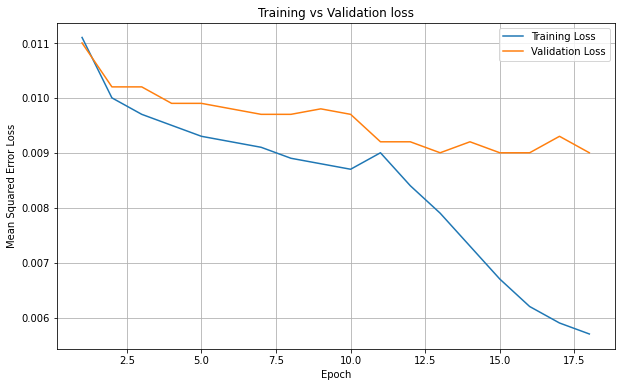

In [23]:
loss = [0.0111 ,0.01, 0.0097 ,0.0095 ,0.0093, 0.0092 ,0.0091, 0.0089, 0.0088, 0.0087, 0.0090, 0.0084, 0.0079, 0.0073, 0.0067, 0.0062, 0.0059, 0.0057]
val_loss = [0.0110 ,0.0102, 0.0102, 0.0099, 0.0099, 0.0098, 0.0097 ,0.0097, 0.0098 ,0.0097 ,0.0092 ,0.0092, 0.0090, 0.0092 ,0.0090 ,0.0090 ,0.0093, 0.0090]
epoch = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11, 12, 13, 14, 15, 16, 17, 18]

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.set_title('Training vs Validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Squared Error Loss')
ax.plot(epoch,loss,label = 'Training Loss')
ax.plot(epoch,val_loss, label = 'Validation Loss')
ax.legend()
ax.grid()

# Prediction 

In [4]:
# Run this line to load the model before prediction
Final_model = tf.keras.models.load_model('model_weights')

In [18]:
def predict(file_path):
    '''
    This function will output plot comparing the groundtruth with predicted image.
    '''
    predict_image_rgb = np.array((imread(file_path)))
    Encoder_image,Extractor_image,AB_channel = process(predict_image_rgb)

  
    fig = plt.figure(figsize=(20,10))
    
    # Black and white image    
    BW_image = rgb2gray(predict_image_rgb)
    
    # Predict image
    Encoder_image = Encoder_image.reshape((1,224,224,1))
    Extractor_image = Extractor_image.reshape((1,299,299,3))
    predicted = Final_model.predict([[Encoder_image],[Extractor_image]])
    Encoder_image = Encoder_image*50
    Encoder_image = Encoder_image+50
    predicted = predicted * 128
    Final_predicted_image = np.concatenate((Encoder_image,predicted),axis=-1)
    Final_predicted_image = lab2rgb(Final_predicted_image[0])
    Final_predicted_image = skimage.transform.resize(Final_predicted_image,(predict_image_rgb.shape[0],predict_image_rgb.shape[1],3),anti_aliasing = True)

    ax = fig.add_subplot(1,3,1)
    ax.set_title('Input image')
    ax.imshow(BW_image,cmap='gray')
    ax.axis('off')
    
    ax = fig.add_subplot(1,3,2)
    ax.set_title('Predicted image')
    ax.imshow(Final_predicted_image)
    ax.axis('off')

    ax = fig.add_subplot(1,3,3)
    ax.set_title('Ground Truth')
    ax.axis('off')
    ax.imshow(predict_image_rgb)

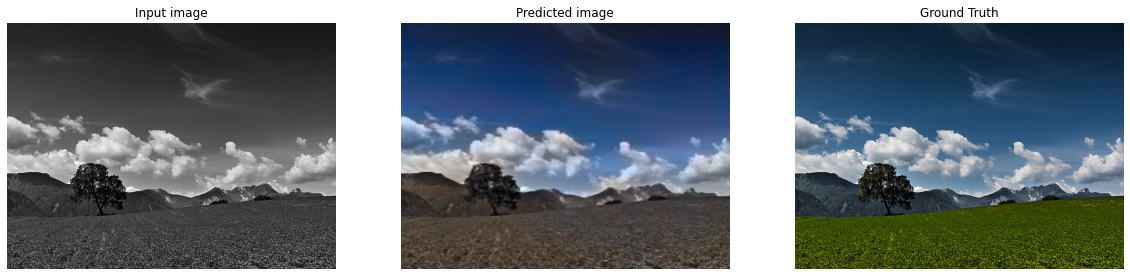

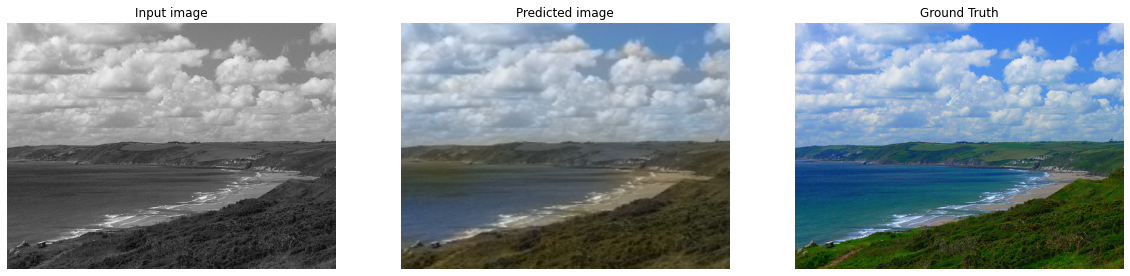

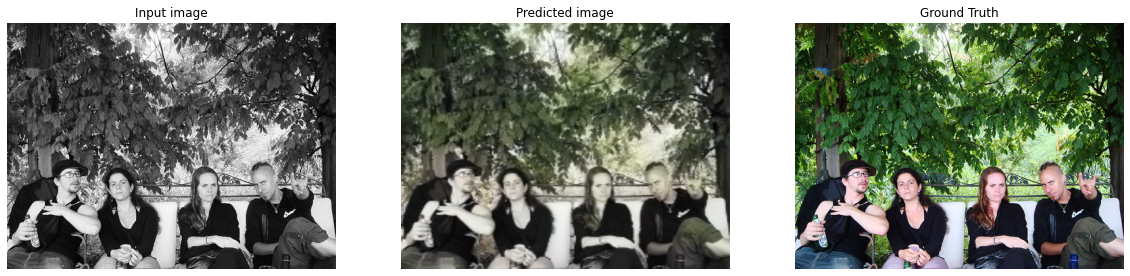

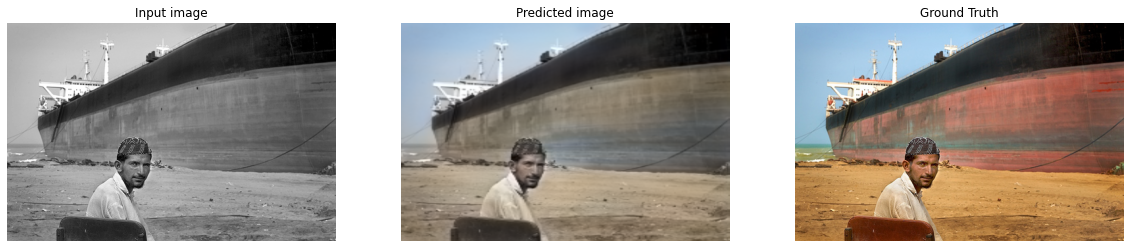

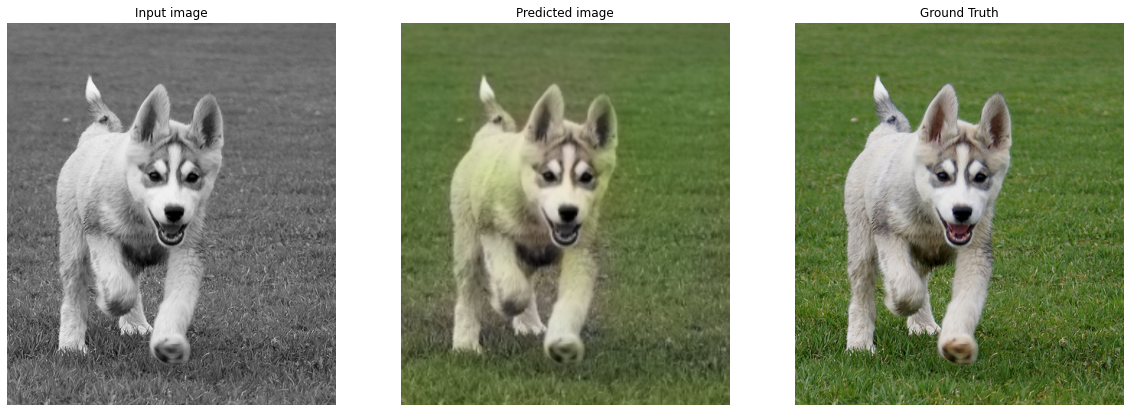

In [19]:
predict('./Prediction/im233.jpg')
predict('./Prediction/im1021.jpg')
predict('./Prediction/im591.jpg')
predict('./Prediction/im1079.jpg')
predict('./Prediction/im22604.jpg')

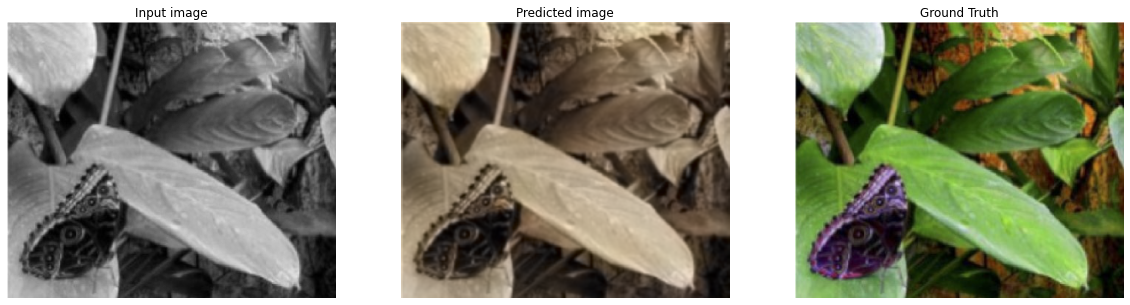

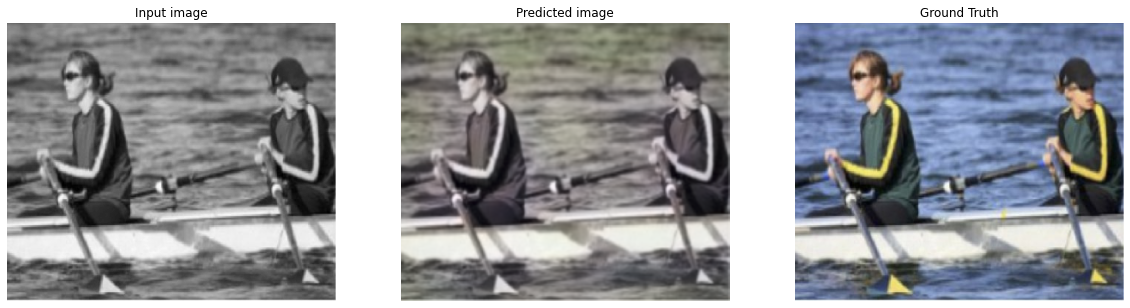

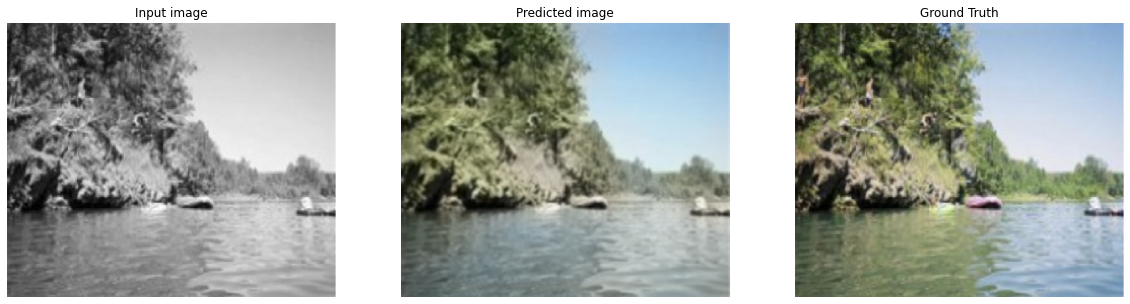

In [20]:
predict('./Prediction/im1.jpg')
predict('./Prediction/im2.jpg')
predict('./Prediction/im3.jpg')

## LAB color space demonstration

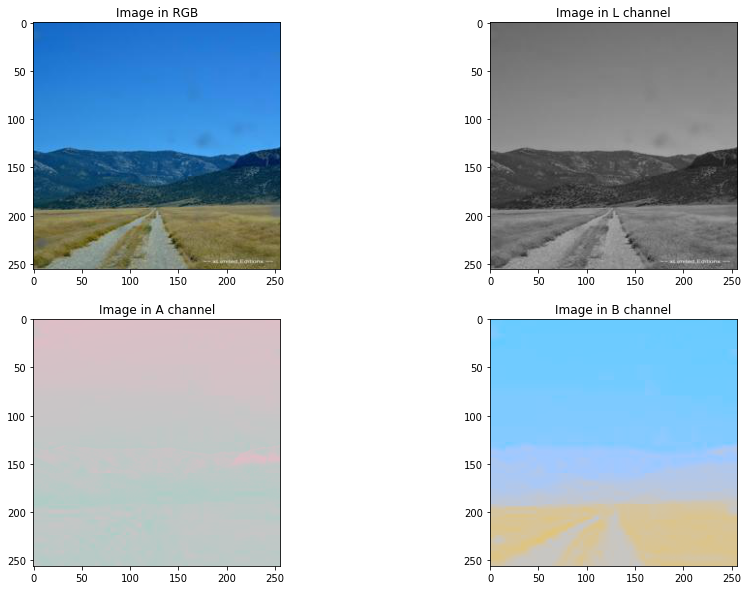

In [21]:
########################################
# This cell demonstrate the picture in #
# LAB color space                      #
########################################

# im22503
example_rgb = np.array(imread('./Dataset/val_256/Places365_val_00000282.jpg'))
example  = np.array(rgb2lab(imread('./Dataset/val_256/Places365_val_00000282.jpg')))
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(2,2,1)
ax.set_title('Image in RGB')
ax.imshow(example_rgb)

# Print the L channel
ax = fig.add_subplot(2,2,2)
L_channel = example.copy()
L_channel[:,:,1]=0
L_channel[:,:,2]=0
im1 = lab2rgb(L_channel)
ax.set_title('Image in L channel')
ax.imshow(im1)

# Print the A channel
ax = fig.add_subplot(2,2,3)
A_channel = example.copy()
A_channel[:,:,0]=80
A_channel[:,:,2]=0
im1 = lab2rgb(A_channel)
ax.set_title('Image in A channel')
ax.imshow(im1)

# Print the B channel
ax = fig.add_subplot(2,2,4)
B_channel = example.copy()
B_channel[:,:,0]=80
B_channel[:,:,1]=0
im1 = lab2rgb(B_channel)
ax.set_title('Image in B channel')
ax.imshow(im1)


In [2]:
!tree ./ /f /a >> README.md